<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 DLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[Reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/DLinear.py <br>
https://anweh.tistory.com/21

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-DLinear']

In [5]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [6]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [80]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        #print(new_input)
        x = self.Linear_plus(new_input)
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [81]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [82]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [83]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),6*1e-8)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

<font color =blue> zero_grad()의 이해 </font><br>
parameter들을 업데이트하는데,
한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 된다.

이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다고 한다.

In [84]:
torch.manual_seed(42)

In [85]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 196.06638877712496 %
smape 185.24988089388575 %
smape 175.6586630163137 %
smape 166.75833129046256 %
smape 158.3470513109575 %
smape 150.34774858352037 %
smape 142.70995117767512 %
smape 135.3978833957025 %
smape 128.38534879405597 %
smape 121.65187965359605 %
smape 115.18029344012166 %
smape 108.95542770798443 %
smape 102.9634786070439 %
smape 97.19177409919382 %
smape 91.62883478298521 %
smape 86.26408155898602 %
smape 81.08746983851606 %
smape 76.0896593158008 %
smape 71.2619968394787 %
smape 66.59612942857352 %
smape 62.0842436949412 %
smape 57.71919350875051 %
smape 53.49422974893224 %
smape 49.40280422132615 %
smape 45.438755335863576 %
smape 41.596263437940365 %
smape 37.86983537743664 %
smape 34.25430100215109 %
smape 30.744787329121642 %
smape 27.336731267254255 %
smape 24.025834474647255 %
smape 20.808033739265642 %
smape 17.679539183427018 %
smape 14.63673366092102 %
smape 11.676172157477218 %
smape 8.79457146103619 %
smape 5.988850751292636 %
smape 3.2560231662981693 

In [86]:
torch.manual_seed(42)

In [87]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [88]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
PATH = './my/Online_Dlearning_Path'
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)
torch.save(model,PATH+'/best_mymodel.pt') #모델의 갱신

SMAPE 0.3247250553686172 %
SMAPE 0.07709734472337004 %
SMAPE 0.003398313027723532 %
SMAPE 0.0010190378244345766 %
SMAPE 0.010812259786916911 %
SMAPE 0.021471131003323762 %
SMAPE 0.002520549141948436 %
SMAPE 0.0013030700324492273 %
SMAPE 0.006901327537271128 %
SMAPE 0.003900248311111909 %
SMAPE 0.0017532527561172628 %
SMAPE 0.012749856782590996 %
SMAPE 0.004540215583809015 %
SMAPE 0.001248772208441551 %
SMAPE 0.005321595596910811 %
SMAPE 0.04733172283283693 %
SMAPE 0.01218738107218087 %
SMAPE 0.002651265766971278 %
SMAPE 0.008303226078169246 %
SMAPE 0.008502095553822642 %
SMAPE 0.005685120142729261 %
SMAPE 0.013567640213281605 %
SMAPE 0.03886729872368733 %
SMAPE 0.006186356206995924 %
SMAPE 0.00032289776001448445 %
SMAPE 0.010087190294854054 %
SMAPE 0.017869996451118197 %
SMAPE 0.00787993430945022 %
SMAPE 0.010171440782272612 %
SMAPE 0.02950692777187669 %
SMAPE 0.0009434044807932196 %
SMAPE 0.0035980401385700134 %
SMAPE 0.0038097100810432494 %
SMAPE 0.0002325442887212148 %
SMAPE 0.00322

SMAPE 0.0050965673356273555 %
SMAPE 0.02209442256852867 %
SMAPE 0.0008329190505094175 %
SMAPE 0.017227484184189734 %
SMAPE 0.022286653106817766 %
SMAPE 0.05563130737064625 %
SMAPE 0.05779358871319573 %
SMAPE 0.029179980787517934 %
SMAPE 0.003834386392455258 %
SMAPE 0.008447431730040478 %
SMAPE 0.011976135952124878 %
SMAPE 0.005475012994445194 %
SMAPE 0.0020568297353520393 %
SMAPE 0.008265274259258604 %
SMAPE 0.004529865014504253 %
SMAPE 0.008034554853466602 %
SMAPE 0.0018964713438833771 %
SMAPE 0.0038745379227833605 %
SMAPE 0.0009600478563811521 %
SMAPE 0.0011477328335445236 %
SMAPE 0.001974826157031373 %
SMAPE 0.001845475471561997 %
SMAPE 0.0023841916345475056 %
SMAPE 0.004181230316135043 %
SMAPE 0.002088941283460599 %
SMAPE 0.002286963409318332 %
SMAPE 0.0016252499106172988 %
SMAPE 0.0007606574807823563 %
SMAPE 0.013610955765557263 %
SMAPE 0.012476895085981711 %
SMAPE 0.0038270488353191467 %
SMAPE 0.006833603230461448 %
SMAPE 0.0030640277538793725 %
SMAPE 0.0007357819034368163 %
SMAP

SMAPE 0.0003486425337655419 %
SMAPE 0.003744615399938311 %
SMAPE 0.0024653735629271978 %
SMAPE 0.006089135613308372 %
SMAPE 0.00537278342216041 %
SMAPE 0.006615887881274318 %
SMAPE 0.0018979936382450546 %
SMAPE 0.0069844949508919285 %
SMAPE 0.016459654900017995 %
SMAPE 0.0016772150336947787 %
SMAPE 0.017296414964562246 %
SMAPE 0.004287418654612907 %
SMAPE 0.0067120881633968565 %
SMAPE 0.015311503259937354 %
SMAPE 0.0021478545736357546 %
SMAPE 0.038118128539622376 %
SMAPE 0.016530522439921924 %
SMAPE 0.004080123922747703 %
SMAPE 0.005011438460698514 %
SMAPE 0.002663652019265328 %
SMAPE 0.01002551386572037 %
SMAPE 0.0031779565473755156 %
SMAPE 0.000550422326853095 %
SMAPE 0.00043323614779922076 %
SMAPE 0.0031516073261528272 %
SMAPE 0.0026956725582607532 %
SMAPE 0.0060568039952073605 %
SMAPE 0.005655189268821914 %
SMAPE 0.005842901339761397 %
SMAPE 0.0015988911353446156 %
SMAPE 0.0027656493502945523 %
SMAPE 0.01952525451028464 %
SMAPE 0.0022085182653768243 %
SMAPE 0.0011203388592662122 %


SMAPE 0.0021921060063334608 %
SMAPE 0.0015292556758765843 %
SMAPE 0.007659659494720472 %
SMAPE 0.006040827604579135 %
SMAPE 0.026695346446523157 %
SMAPE 0.015312667338889696 %
SMAPE 0.0032997945199895184 %
SMAPE 0.001008313312752307 %
SMAPE 0.00490083956253784 %
SMAPE 0.05714410753489573 %
SMAPE 0.029217217045840016 %
SMAPE 0.0022107422622923423 %
SMAPE 0.001290012484247427 %
SMAPE 0.0067682783408997685 %
SMAPE 0.004510842428288697 %
SMAPE 0.004341566314707279 %
SMAPE 0.0035403716848065874 %
SMAPE 0.00018323591541502537 %
SMAPE 0.00317956906337713 %
SMAPE 0.01358943315037209 %
SMAPE 0.004078726124546961 %
SMAPE 0.0041048867589239535 %
SMAPE 0.003592297595872651 %
SMAPE 0.0009462363148031726 %
SMAPE 0.010058262420386654 %
SMAPE 0.013889368074728736 %
SMAPE 0.0003630123481812575 %
SMAPE 0.01001633271226865 %
SMAPE 0.003891437731951441 %
SMAPE 0.0005113768197873014 %
SMAPE 0.0029831383505865006 %
SMAPE 0.0051909969825771896 %
SMAPE 0.0025882736749025526 %
SMAPE 0.0036651613883975642 %
SMA

SMAPE 0.005039968404730644 %
SMAPE 0.0135916984053992 %
SMAPE 0.009480802468289085 %
SMAPE 0.007917663839265288 %
SMAPE 0.0005108209805158026 %
SMAPE 0.005971517778021962 %
SMAPE 0.0005781174684500456 %
SMAPE 0.002549963012711487 %
SMAPE 0.003461306899666283 %
SMAPE 0.01500958756678017 %
SMAPE 0.00771874851272969 %
SMAPE 0.002792284677866519 %
SMAPE 0.0004975051956535026 %
SMAPE 0.0048536156653540274 %
SMAPE 0.004188216117412935 %
SMAPE 0.006311587822523279 %
SMAPE 0.0037738729083969247 %
SMAPE 0.025203993878164965 %
SMAPE 0.0017428594085799885 %
SMAPE 0.0007880429961630853 %
SMAPE 0.0020324294570031043 %
SMAPE 0.01016407125752039 %
SMAPE 0.0051145965549466155 %
SMAPE 0.003531138317228511 %
SMAPE 0.020885054503956724 %
SMAPE 0.01575957759251878 %
SMAPE 0.000612037445137048 %
SMAPE 0.0017408139557772986 %
SMAPE 0.0007199495005778545 %
SMAPE 0.0004928078410557646 %
SMAPE 0.008162482285626993 %
SMAPE 0.005739299714889512 %
SMAPE 0.013679775206782097 %
SMAPE 0.0014971433337223061 %
SMAPE 0

SMAPE 0.0028107970678235006 %
SMAPE 0.009459603305003839 %
SMAPE 0.007054330813332398 %
SMAPE 0.0015641229224456765 %
SMAPE 0.00023348523811250743 %
SMAPE 0.009589867420999099 %
SMAPE 0.0030543445968760348 %
SMAPE 0.0009347879762273692 %
SMAPE 0.0018047202896696035 %
SMAPE 0.000525446705772481 %
SMAPE 0.0007450498770822378 %
SMAPE 0.006236777226028778 %
SMAPE 0.030023499598243575 %
SMAPE 0.013565646395406363 %
SMAPE 0.0003943165340558608 %
SMAPE 0.0006697414806353663 %
SMAPE 0.009293410569242155 %
SMAPE 0.011540556041808259 %
SMAPE 0.005009449942008359 %
SMAPE 0.007538581046048876 %
SMAPE 0.025129118674982465 %
SMAPE 0.01678969097110894 %
SMAPE 0.001692791222765777 %
SMAPE 0.012267297175696967 %
SMAPE 0.017899069119039268 %
SMAPE 0.01061308030756436 %
SMAPE 0.006120661975771213 %
SMAPE 0.0004723565536721708 %
SMAPE 0.0002995681383026749 %
SMAPE 0.002245950122826912 %
SMAPE 0.0023621769163924 %
SMAPE 0.00037727048588465095 %
SMAPE 0.0018386324465140547 %
SMAPE 0.0049918904159724775 %
SM

SMAPE 0.0019073356760941351 %
SMAPE 0.013024403943290963 %
SMAPE 0.0011521660597964 %
SMAPE 0.004575078897005369 %
SMAPE 0.0036139246945126042 %
SMAPE 0.00927218257956497 %
SMAPE 0.005135839670103337 %
SMAPE 0.006112532337766652 %
SMAPE 0.0043556390270964584 %
SMAPE 0.005094685424836598 %
SMAPE 0.0018741203062333511 %
SMAPE 0.0017821920551668313 %
SMAPE 0.015346066534846159 %
SMAPE 0.002589614968705689 %
SMAPE 0.005525285117393253 %
SMAPE 0.0022170871083631027 %
SMAPE 0.0013814704564651947 %
SMAPE 0.006556854782125753 %
SMAPE 0.0022555440671467863 %
SMAPE 0.007323089133301153 %
SMAPE 0.007908526585993059 %
SMAPE 0.00520866166712608 %
SMAPE 0.016767668013990544 %
SMAPE 0.0014491355041315046 %
SMAPE 0.006535323170567153 %
SMAPE 0.003519029008344887 %
SMAPE 0.00445295026901249 %
SMAPE 0.009118053447480179 %
SMAPE 0.010071209732878117 %
SMAPE 0.0032721129575037367 %
SMAPE 0.003039011025890659 %
SMAPE 0.007841587875567768 %
SMAPE 0.00039534923342898765 %
SMAPE 0.009677647324181748 %
SMAPE 0

SMAPE 0.002320001272678951 %
SMAPE 0.011533230695846441 %
SMAPE 0.001417025996488519 %
SMAPE 0.0053767725411830725 %
SMAPE 0.004945429421411518 %
SMAPE 0.010988525430434493 %
SMAPE 0.011514032472291547 %
SMAPE 0.005164859717041281 %
SMAPE 0.0028591409042064697 %
SMAPE 0.006207590794446105 %
SMAPE 0.0029853712715635083 %
SMAPE 0.0022074387024133557 %
SMAPE 0.0019470968965293878 %
SMAPE 0.0009348236748110139 %
SMAPE 0.01144256969740809 %
SMAPE 0.00876442345517603 %
SMAPE 0.00351757724767765 %
SMAPE 0.03579845310815699 %
SMAPE 0.044709109443402895 %
SMAPE 0.0021815410595991125 %
SMAPE 0.0004500648616101444 %
SMAPE 0.002420640094562998 %
SMAPE 0.00730568464580017 %
SMAPE 0.0012370540537176566 %
SMAPE 0.016798677032049625 %
SMAPE 0.010874092857591222 %
SMAPE 0.00405837358135841 %
SMAPE 0.006281051138628868 %
SMAPE 0.004795847808260589 %
SMAPE 0.0005331556269112525 %
SMAPE 0.0053245753920379 %
SMAPE 0.0035249678395317115 %
SMAPE 0.0015740382872451162 %
SMAPE 0.004923399168617948 %
SMAPE 0.00

SMAPE 0.0033619446265902293 %
SMAPE 0.0029483383068225066 %
SMAPE 0.009884421547418754 %
SMAPE 0.00045505689226388313 %
SMAPE 0.0008950697647946981 %
SMAPE 0.0015108355128887752 %
SMAPE 0.010212046217930038 %
SMAPE 0.012817862068501997 %
SMAPE 0.011428282419274183 %
SMAPE 0.007990299436585246 %
SMAPE 0.013205369201067185 %
SMAPE 0.0016451561483705743 %
SMAPE 0.012479708946159462 %
SMAPE 0.0050696226142648015 %
SMAPE 0.0041723351435791756 %
SMAPE 0.011079067767717277 %
SMAPE 0.010133708346145909 %
SMAPE 0.0031846691451136167 %
SMAPE 0.004599226598600126 %
SMAPE 0.01277155548748965 %
SMAPE 0.005350479607571401 %
SMAPE 0.012631520415226305 %
SMAPE 0.0127911829237064 %
SMAPE 0.0037446874917037576 %
SMAPE 0.02649362518943121 %
SMAPE 0.021079509450700584 %
SMAPE 0.0011228609216544783 %
SMAPE 0.007750937799485769 %
SMAPE 0.0028593400097634003 %
SMAPE 0.001732281456767737 %
SMAPE 0.008196638335583373 %
SMAPE 0.00034191777569958504 %
SMAPE 0.0031803332604312122 %
SMAPE 0.006438964192255981 %
SM

SMAPE 0.007063942025965274 %
SMAPE 0.0032949654318485955 %
SMAPE 0.006720756310357956 %
SMAPE 0.01361580842717558 %
SMAPE 0.008885749342752547 %
SMAPE 0.0011251941358167983 %
SMAPE 0.0008882260363662908 %
SMAPE 0.0008623318573484084 %
SMAPE 0.0012815216335013702 %
SMAPE 0.010020436903573682 %
SMAPE 0.0022265335300915012 %
SMAPE 0.003973775690361947 %
SMAPE 0.01523185218846379 %
SMAPE 0.0062569176248246094 %
SMAPE 0.02591040048520199 %
SMAPE 0.00029264706231657556 %
SMAPE 0.013633195089113315 %
SMAPE 0.0013148997484080382 %
SMAPE 0.009957845076314698 %
SMAPE 0.012787155411047023 %
SMAPE 0.002975740982890329 %
SMAPE 0.0038390004101103163 %
SMAPE 0.0024567891300648625 %
SMAPE 0.005095136936958511 %
SMAPE 0.0013560964281964516 %
SMAPE 0.010656388716654419 %
SMAPE 0.0008803927990896908 %
SMAPE 0.006549781508383035 %
SMAPE 0.02645120131865042 %
SMAPE 0.013168701774212366 %
SMAPE 0.00754444207547067 %
SMAPE 0.004583476038312995 %
SMAPE 0.0033378606235885395 %
SMAPE 0.00044632421074197737 %
SM

SMAPE 0.0096047461355937 %
SMAPE 0.00122636696167433 %
SMAPE 0.0024885475572489213 %
SMAPE 0.006607882615895733 %
SMAPE 0.007970084135834554 %
SMAPE 0.0004504140109133914 %
SMAPE 0.00986862565514457 %
SMAPE 0.002226660443646722 %
SMAPE 0.0017904253509897217 %
SMAPE 0.007106960209952717 %
SMAPE 0.003052149664085846 %
SMAPE 0.007822224129427013 %
SMAPE 0.001523749249358275 %
SMAPE 0.0029123474032388685 %
SMAPE 0.0007995569806311664 %
SMAPE 0.013185254268535118 %
SMAPE 0.0013000586303917316 %
SMAPE 0.012491937642266748 %
SMAPE 0.01653681844749144 %
SMAPE 0.007246112594259557 %
SMAPE 0.01564712736679752 %
SMAPE 0.0012124123472858628 %
SMAPE 0.00041341151900553536 %
SMAPE 0.00968301639322533 %
SMAPE 0.017905248260831286 %
SMAPE 0.003439692504599634 %
SMAPE 0.003984152050705347 %
SMAPE 0.0006710316932725391 %
SMAPE 0.004875447816061751 %
SMAPE 0.002009942135366316 %
SMAPE 0.004962616406359643 %
SMAPE 0.001222422137210799 %
SMAPE 0.004125458470426224 %
SMAPE 0.010135689755898625 %
SMAPE 0.000

SMAPE 0.08364383948867271 %
SMAPE 0.13512771476689522 %
SMAPE 0.07337689440512918 %
SMAPE 0.016836829180249424 %
SMAPE 0.09735406500794852 %
SMAPE 0.0002553682538746216 %
SMAPE 0.014345785004508116 %
SMAPE 0.08350065663591977 %
SMAPE 0.04759487945406704 %
SMAPE 0.09763064363642115 %
SMAPE 0.31205618544481695 %
SMAPE 0.02980487018498934 %
SMAPE 0.04150914651791027 %
SMAPE 0.10323585122841905 %
SMAPE 0.088400505596951 %
SMAPE 0.05017507502032004 %
SMAPE 0.014368990831208349 %
SMAPE 0.049621966959392694 %
SMAPE 0.2977422643452883 %
SMAPE 0.014336730321019788 %
SMAPE 0.007776940964532741 %
SMAPE 0.0051598663845879855 %
SMAPE 0.007840827349603785 %
SMAPE 0.06050007284960656 %
SMAPE 0.04702568260069029 %
SMAPE 0.004805941806722558 %
SMAPE 0.03252583429218703 %
SMAPE 0.11800263932218513 %
SMAPE 0.22582124744076282 %
SMAPE 0.0636023638143115 %
SMAPE 0.009615692514010732 %
SMAPE 0.03595489189029877 %
SMAPE 0.10264167431250826 %
SMAPE 0.08049652452427836 %
SMAPE 0.0023586274708549126 %
SMAPE 0.0

SMAPE 0.06397119817961539 %
SMAPE 0.05075056338409923 %
SMAPE 0.029320270245079882 %
SMAPE 0.026617934906767 %
SMAPE 0.12691222198827745 %
SMAPE 0.01821715669464652 %
SMAPE 0.014727128713943216 %
SMAPE 0.1937841643812135 %
SMAPE 0.05627889239292472 %
SMAPE 0.02618936896955404 %
SMAPE 0.11685291019125543 %
SMAPE 0.031352757709157686 %
SMAPE 0.06872855733195138 %
SMAPE 0.019097495537067743 %
SMAPE 0.0077965738332750325 %
SMAPE 0.13745698237016768 %
SMAPE 0.2643065060256049 %
SMAPE 0.01679293940333082 %
SMAPE 0.004231222467929285 %
SMAPE 0.04509731104177206 %
SMAPE 0.33643671323079616 %
SMAPE 0.004056499244484257 %
SMAPE 0.0051953489037259715 %
SMAPE 0.07238688410780014 %
SMAPE 0.004553287436920073 %
SMAPE 0.31602667772676796 %
SMAPE 0.03816354300286662 %
SMAPE 0.05589160170399054 %
SMAPE 0.22338379040593281 %
SMAPE 0.009931934448118795 %
SMAPE 0.03654855867662832 %
SMAPE 0.0985484384373194 %
SMAPE 0.03920680230135076 %
SMAPE 0.008624997769899778 %
SMAPE 0.002128248143336009 %
SMAPE 0.075

SMAPE 0.0682522633201188 %
SMAPE 0.0924052227564971 %
SMAPE 0.10013993393101829 %
SMAPE 0.12578910393131082 %
SMAPE 0.0006117676531331995 %
SMAPE 0.025000462766854525 %
SMAPE 0.03907625839718776 %
SMAPE 0.1559469182320754 %
SMAPE 0.10039665652300302 %
SMAPE 0.1185303898400889 %
SMAPE 0.030655017316121302 %
SMAPE 0.004518264921699711 %
SMAPE 0.03783446726615125 %
SMAPE 0.049004938366124406 %
SMAPE 0.054913574116199015 %
SMAPE 0.02836418042511468 %
SMAPE 0.04772966510677179 %
SMAPE 0.0009887824740957285 %
SMAPE 0.04913920331227928 %
SMAPE 0.01483133316060048 %
SMAPE 0.17731137346709147 %
SMAPE 0.038669283370794005 %
SMAPE 0.040916680734255806 %
SMAPE 0.16646081789804157 %
SMAPE 0.013442314960130375 %
SMAPE 0.07120046190857465 %
SMAPE 0.007603602964842082 %
SMAPE 0.04875981739883173 %
SMAPE 0.004666581271266068 %
SMAPE 0.139951793641103 %
SMAPE 0.12668621430157145 %
SMAPE 0.24323749262839556 %
SMAPE 0.00824963112546584 %
SMAPE 0.09360555768148515 %
SMAPE 0.23317096679238603 %
SMAPE 0.0486

SMAPE 0.04021418883890249 %
SMAPE 0.04583279142457286 %
SMAPE 0.014715399849876576 %
SMAPE 0.09069099123951219 %
SMAPE 0.09645684936003818 %
SMAPE 0.024875867947486082 %
SMAPE 0.00920990821153822 %
SMAPE 0.2725127637386322 %
SMAPE 0.07982932628590333 %
SMAPE 0.011079219205100799 %
SMAPE 0.00481707147771715 %
SMAPE 0.017133490975197674 %
SMAPE 0.03443288821711121 %
SMAPE 0.02699829958446287 %
SMAPE 0.013429635654347294 %
SMAPE 0.022582551315053934 %
SMAPE 0.01662607327892829 %
SMAPE 0.05278511238441297 %
SMAPE 0.008671559469760837 %
SMAPE 0.14653220589661942 %
SMAPE 0.07335687032309579 %
SMAPE 0.20794792007654905 %
SMAPE 0.02023878675316837 %
SMAPE 0.2371708994032815 %
SMAPE 0.07076876579293412 %
SMAPE 0.062165515093511196 %
SMAPE 0.006140752757012535 %
SMAPE 0.01683775425077272 %
SMAPE 0.23536710313055664 %
SMAPE 0.16980108529969584 %
SMAPE 0.018680073561327504 %
SMAPE 0.09156631458267839 %
SMAPE 0.00033146178669341 %
SMAPE 0.08605918154535175 %
SMAPE 0.009674427579611233 %
SMAPE 0.070

SMAPE 0.07170186878892082 %
SMAPE 0.05648894792749104 %
SMAPE 0.010431252796557544 %
SMAPE 0.09736181827007329 %
SMAPE 0.000889943795925774 %
SMAPE 0.01865965985479079 %
SMAPE 0.04530913671453618 %
SMAPE 0.04494722476931656 %
SMAPE 0.026044351643960795 %
SMAPE 0.3450475810095668 %
SMAPE 0.1071413509841932 %
SMAPE 0.013245332749306726 %
SMAPE 0.018719690499075625 %
SMAPE 0.13898585559581988 %
SMAPE 0.00157540700644887 %
SMAPE 0.06739676110828441 %
SMAPE 0.0016486718403143643 %
SMAPE 0.1580057960400154 %
SMAPE 0.003923138226809897 %
SMAPE 0.09711733394863131 %
SMAPE 0.0352939510747774 %
SMAPE 0.0013198933142746228 %
SMAPE 0.05142500219079693 %
SMAPE 0.01298372443349649 %
SMAPE 0.04544338450386931 %
SMAPE 0.03603132121497765 %
SMAPE 0.010427690955907565 %
SMAPE 0.05124704352088827 %
SMAPE 0.0018606647074150826 %
SMAPE 0.006911248466735742 %
SMAPE 0.004664900165806785 %
SMAPE 0.012084623115129034 %
SMAPE 0.003455305535354114 %
SMAPE 0.0050782781195692905 %
SMAPE 0.008682649165280054 %
SMAP

SMAPE 0.005492709356644809 %
SMAPE 0.030586767748218335 %
SMAPE 0.007301368118710627 %
SMAPE 0.026875061746864052 %
SMAPE 0.0016749476919812878 %
SMAPE 0.19912637677043676 %
SMAPE 0.11765673991652648 %
SMAPE 0.06517445422718993 %
SMAPE 0.049148544394256526 %
SMAPE 0.049091565883145456 %
SMAPE 0.042382007544802036 %
SMAPE 0.011447780031105026 %
SMAPE 0.007321803404238381 %
SMAPE 1.0887343436479568 %
SMAPE 1.3553211903199553 %
SMAPE 1.4098508674651384 %
SMAPE 1.5452960766851902 %
SMAPE 1.1255242861807346 %
SMAPE 0.7861515274271369 %
SMAPE 0.5358790690079331 %
SMAPE 0.259766819071956 %
SMAPE 0.22332614677725357 %
SMAPE 0.0953552979071901 %
SMAPE 0.004415587818911604 %
SMAPE 0.014101446440704988 %
SMAPE 0.05234268804809972 %
SMAPE 0.01673935699139406 %
SMAPE 0.05110518523304109 %
SMAPE 0.8169559459201993 %
SMAPE 1.4196472754701972 %
SMAPE 1.413544905371964 %
SMAPE 1.588443461805582 %
SMAPE 0.012438191629044582 %
SMAPE 1.6205781307071447 %
SMAPE 1.2791589749976993 %
SMAPE 0.8050012863241135

SMAPE 0.10407066808915033 %
SMAPE 0.04499608831133628 %
SMAPE 0.015967736711104408 %
SMAPE 0.20460466557415202 %
SMAPE 0.050017699199770504 %
SMAPE 0.23740381014067682 %
SMAPE 0.05781607196627191 %
SMAPE 0.0015023077364588744 %
SMAPE 0.01484545122256975 %
SMAPE 0.07117526367142091 %
SMAPE 0.007844095190876033 %
SMAPE 0.04907104871858792 %
SMAPE 0.025619648676155293 %
SMAPE 0.02077125602573915 %
SMAPE 0.010138739637831407 %
SMAPE 0.010945120930614394 %
SMAPE 0.0013145859690126827 %
SMAPE 0.020471958126108802 %
SMAPE 0.018852011738644592 %
SMAPE 0.014363433220921706 %
SMAPE 0.024279631372181143 %
SMAPE 0.0013113475016552911 %
SMAPE 0.08891073421841611 %
SMAPE 0.04297055609868039 %
SMAPE 0.11361671122176631 %
SMAPE 0.08973541640716576 %
SMAPE 0.07564863771278851 %
SMAPE 0.07784514847719493 %
SMAPE 0.002254274462934802 %
SMAPE 0.026398714436936643 %
SMAPE 0.015251813414636219 %
SMAPE 0.0013917764456436998 %
SMAPE 0.007081999537149386 %
SMAPE 0.01732998164730759 %
SMAPE 0.005122704269410860

SMAPE 0.1293835735596076 %
SMAPE 0.4308116910979151 %
SMAPE 0.09608097802379234 %
SMAPE 0.4827220116276294 %
SMAPE 0.0957229584300876 %
SMAPE 0.04775689600430155 %
SMAPE 0.32896612281911075 %
SMAPE 0.3729775424581021 %
SMAPE 0.010846983025494694 %
SMAPE 0.6517916643060744 %
SMAPE 0.0026343440067080337 %
SMAPE 0.016798361867387257 %
SMAPE 0.5578238354064524 %
SMAPE 0.007464831141156481 %
SMAPE 0.07400597861169445 %
SMAPE 0.26915584434755147 %
SMAPE 0.5451787642668933 %
SMAPE 0.18954685461358167 %
SMAPE 0.056366396537327994 %
SMAPE 0.3211423675529659 %
SMAPE 0.006142994045944761 %
SMAPE 0.13563897690528393 %
SMAPE 0.004032499467513162 %
SMAPE 0.27566389576531947 %
SMAPE 0.029275289519659964 %
SMAPE 0.4129941463470459 %
SMAPE 0.2768064544070512 %
SMAPE 0.48084910353645677 %
SMAPE 0.1395068399297088 %
SMAPE 0.1801479425339494 %
SMAPE 0.008425515871152811 %
SMAPE 0.0077077406473904375 %
SMAPE 0.2746771661331877 %
SMAPE 0.13825848582928302 %
SMAPE 0.38351117563433945 %
SMAPE 0.00826182839744

SMAPE 0.07976191624788953 %
SMAPE 0.005115925975246682 %
SMAPE 0.006606444220523144 %
SMAPE 0.020989147858585966 %
SMAPE 0.08488973721000548 %
SMAPE 0.02075685355090684 %
SMAPE 0.004331772568583858 %
SMAPE 0.0005236554217944445 %
SMAPE 0.014854769096984912 %
SMAPE 0.06719405982005355 %
SMAPE 0.0469677085436615 %
SMAPE 0.2542421651305631 %
SMAPE 0.022230515883194357 %
SMAPE 0.07694319093184276 %
SMAPE 0.028201382729321267 %
SMAPE 0.020605209508346434 %
SMAPE 0.13939600175717715 %
SMAPE 0.0008454203211272215 %
SMAPE 0.015143522450244973 %
SMAPE 0.1281775277526549 %
SMAPE 0.10397536279162978 %
SMAPE 0.04167570994150083 %
SMAPE 0.025618000620170278 %
SMAPE 0.023542522964078216 %
SMAPE 0.0013611984157932966 %
SMAPE 0.018544455254129844 %
SMAPE 0.03684076918102619 %
SMAPE 0.03146181540515158 %
SMAPE 0.024369934095020085 %
SMAPE 0.023019654296717817 %
SMAPE 0.009655325506855661 %
SMAPE 0.0016891824094784624 %
SMAPE 0.023123197768711634 %
SMAPE 0.0022918362819837057 %
SMAPE 0.09552919481393474

SMAPE 0.009350137209729326 %
SMAPE 0.014810868167671742 %
SMAPE 0.03312935789060134 %
SMAPE 0.007647708662489094 %
SMAPE 0.00547153193883787 %
SMAPE 0.016823555543282964 %
SMAPE 0.0027935557485392337 %
SMAPE 0.06638325754875041 %
SMAPE 0.022560711610395856 %
SMAPE 0.030319839217781922 %
SMAPE 0.0032534194105835468 %
SMAPE 0.027067952924824112 %
SMAPE 0.0017016279194876915 %
SMAPE 0.01322051387700185 %
SMAPE 0.008002585607584933 %
SMAPE 0.04827540721794321 %
SMAPE 0.2961239862488583 %
SMAPE 0.1716495205037063 %
SMAPE 0.06540964921502024 %
SMAPE 0.1623249654803658 %
SMAPE 0.03698638246669361 %
SMAPE 0.010262796786513206 %
SMAPE 0.3737947659101337 %
SMAPE 0.182351105439011 %
SMAPE 0.010529287355645067 %
SMAPE 0.020745741112364158 %
SMAPE 0.0236752776514777 %
SMAPE 0.0038435657015725155 %
SMAPE 0.02181958372364079 %
SMAPE 0.007638518874429678 %
SMAPE 0.1689183571288595 %
SMAPE 0.03027922466117161 %
SMAPE 0.026669205401105952 %
SMAPE 0.03288985839668612 %
SMAPE 0.1684381882150774 %
SMAPE 0.

SMAPE 0.023288624356410992 %
SMAPE 0.02487330269264021 %
SMAPE 0.007669584539705453 %
SMAPE 0.06422805275371957 %
SMAPE 0.1185339433172885 %
SMAPE 0.05767580063678678 %
SMAPE 0.006734537379230686 %
SMAPE 0.008714704196762568 %
SMAPE 0.15097032403537014 %
SMAPE 0.06236772207887498 %
SMAPE 0.023393827142697887 %
SMAPE 0.01992309664728964 %
SMAPE 0.0019913486825515747 %
SMAPE 0.0025301837303857155 %
SMAPE 0.002856348717948265 %
SMAPE 0.00438474334509209 %
SMAPE 0.007509622805145 %
SMAPE 0.0027234822819650617 %
SMAPE 0.07446651460941212 %
SMAPE 0.04193249288962164 %
SMAPE 0.04711427575423954 %
SMAPE 0.0675582456825623 %
SMAPE 0.04233376791626142 %
SMAPE 0.00619290427556507 %
SMAPE 0.05502834178179228 %
SMAPE 0.03706226780150246 %
SMAPE 0.07470983936104858 %
SMAPE 0.0010377487813144626 %
SMAPE 0.1000633833637039 %
SMAPE 0.013016791289743423 %
SMAPE 0.001544605455421788 %
SMAPE 0.00278582941692207 %
SMAPE 0.11495738843669301 %
SMAPE 0.003932902916517378 %
SMAPE 0.04339029364356861 %
SMAPE 0.

SMAPE 0.04710930647195255 %
SMAPE 0.029614977166374956 %
SMAPE 0.037155530808696824 %
SMAPE 0.12947946991926074 %
SMAPE 0.04608456194807786 %
SMAPE 0.009515058259353282 %
SMAPE 0.04995880050387314 %
SMAPE 0.04090835884699118 %
SMAPE 0.02703395259624131 %
SMAPE 0.0723394480078241 %
SMAPE 0.02004539293199059 %
SMAPE 0.007980722513536875 %
SMAPE 0.013041696544689783 %
SMAPE 0.005389605799862807 %
SMAPE 0.016170470189592834 %
SMAPE 0.008329658882473723 %
SMAPE 0.013480564165263331 %
SMAPE 0.030723575471938606 %
SMAPE 0.060069454714152926 %
SMAPE 0.04783720510198464 %
SMAPE 0.041498394400321104 %
SMAPE 0.03260166035329348 %
SMAPE 0.0014526351998540576 %
SMAPE 0.08923142542039386 %
SMAPE 0.005270393359793957 %
SMAPE 0.00664014660496548 %
SMAPE 0.05963507573318338 %
SMAPE 0.001958558020817236 %
SMAPE 0.029297347094285442 %
SMAPE 0.0004975209596125296 %
SMAPE 0.0053515229526652774 %
SMAPE 0.01700647970733371 %
SMAPE 0.005817758539677698 %
SMAPE 0.002714487993102921 %
SMAPE 0.006742034317440471

SMAPE 0.046452771677707005 %
SMAPE 0.023397642661223017 %
SMAPE 0.01933109750859785 %
SMAPE 0.006762444060257167 %
SMAPE 0.02913956561185671 %
SMAPE 0.005755057158097543 %
SMAPE 0.0009651756407578205 %
SMAPE 0.0008710104050493329 %
SMAPE 0.027298698194414325 %
SMAPE 0.007460821260096395 %
SMAPE 0.04161813672772041 %
SMAPE 0.026529344487471466 %
SMAPE 0.005299765029434411 %
SMAPE 0.0030142701860427223 %
SMAPE 0.005727267971309402 %
SMAPE 0.01446883852095482 %
SMAPE 0.0024461505400097394 %
SMAPE 0.08026367935030976 %
SMAPE 0.011661937068993211 %
SMAPE 0.03811310423733971 %
SMAPE 0.03474699958292149 %
SMAPE 0.0009280494060845967 %
SMAPE 0.050418114814192456 %
SMAPE 0.032385476317244866 %
SMAPE 0.02135799787072301 %
SMAPE 0.0018206535686715595 %
SMAPE 0.010002126931624389 %
SMAPE 0.0009169838276932296 %
SMAPE 0.009635104568729957 %
SMAPE 0.006735432075643644 %
SMAPE 0.022452516305520476 %
SMAPE 0.009143146351810572 %
SMAPE 0.0021874320401380487 %
SMAPE 0.005741617156076018 %
SMAPE 0.000773

SMAPE 0.004987662026259443 %
SMAPE 0.009706326402451282 %
SMAPE 0.006932052419728052 %
SMAPE 0.0025454293018114527 %
SMAPE 0.003622586846233844 %
SMAPE 0.006861777901846722 %
SMAPE 0.014007874815547439 %
SMAPE 0.0063802187133390476 %
SMAPE 0.013856962119021432 %
SMAPE 0.005940824373979581 %
SMAPE 0.029244085597028402 %
SMAPE 0.013635904659217601 %
SMAPE 0.006127181517115332 %
SMAPE 0.013035578949654791 %
SMAPE 0.0012766204510938906 %
SMAPE 0.007372685277402979 %
SMAPE 0.006493386589710326 %
SMAPE 0.013778817766649354 %
SMAPE 0.002197428383396982 %
SMAPE 0.08445374750550627 %
SMAPE 0.009921576637793805 %
SMAPE 0.025232022978343593 %
SMAPE 0.010774908232761504 %
SMAPE 0.006255517798926746 %
SMAPE 0.003674667732269654 %
SMAPE 0.06957680341770356 %
SMAPE 0.03305856953866737 %
SMAPE 0.030203308884836133 %
SMAPE 0.0006240943088329232 %
SMAPE 0.025463067122927896 %
SMAPE 0.0016946249558884574 %
SMAPE 0.007970067265119951 %
SMAPE 0.03490116672551835 %
SMAPE 0.011682419409495992 %
SMAPE 0.01521

SMAPE 0.004752161501926366 %
SMAPE 0.04631223332245327 %
SMAPE 0.0005129644375330145 %
SMAPE 0.0027893024461889127 %
SMAPE 0.00531104612002764 %
SMAPE 0.013841590396012293 %
SMAPE 0.019878331386848913 %
SMAPE 0.015465986320961633 %
SMAPE 0.020516698301321412 %
SMAPE 0.005278011328243792 %
SMAPE 0.001587092738915885 %
SMAPE 0.008757167114907816 %
SMAPE 0.012618166155903054 %
SMAPE 0.0046735276427227745 %
SMAPE 0.014995521890057262 %
SMAPE 0.02972331506214232 %
SMAPE 0.02166852758227833 %
SMAPE 0.0015357758978211677 %
SMAPE 0.012770394410466679 %
SMAPE 0.0019507720817273366 %
SMAPE 0.004622153840188048 %
SMAPE 0.007871335184468364 %
SMAPE 0.0019487000931235343 %
SMAPE 0.00527953093968847 %
SMAPE 0.030793383505056227 %
SMAPE 0.0036325735447277907 %
SMAPE 0.021152283540672556 %
SMAPE 0.007038833451311177 %
SMAPE 0.02630812906719626 %
SMAPE 0.0009613493795868068 %
SMAPE 0.003527351252387234 %
SMAPE 0.002377273170282024 %
SMAPE 0.055752200098140754 %
SMAPE 0.0019939290327286585 %
SMAPE 0.031

SMAPE 0.004103736387058632 %
SMAPE 0.004729647300436568 %
SMAPE 0.01025912429309983 %
SMAPE 0.0021250522954971984 %
SMAPE 0.004378162454031553 %
SMAPE 0.0044441638822263485 %
SMAPE 0.007625714962941288 %
SMAPE 0.00030234450457555795 %
SMAPE 0.0015819159038699127 %
SMAPE 0.013837739733716603 %
SMAPE 0.0011494086517132018 %
SMAPE 0.004682477175421695 %
SMAPE 0.0011996796460280734 %
SMAPE 0.0006145485907751436 %
SMAPE 0.006366324959941494 %
SMAPE 0.004845333876772884 %
SMAPE 0.00812011239627708 %
SMAPE 0.0006527577507071669 %
SMAPE 0.0023453160475170876 %
SMAPE 0.004063784403783188 %
SMAPE 0.0028607068686312687 %
SMAPE 0.019892996936732743 %
SMAPE 0.00608610034691992 %
SMAPE 0.0007270663309242309 %
SMAPE 0.037685253683775954 %
SMAPE 0.001527111259576941 %
SMAPE 0.0200180983343472 %
SMAPE 0.010246533643424982 %
SMAPE 0.00044646407491200085 %
SMAPE 0.0048761165444375365 %
SMAPE 0.021626339825800756 %
SMAPE 0.013536174981851445 %
SMAPE 0.0028075619574110533 %
SMAPE 0.0057110972500495905 %
SM

SMAPE 0.007359230191966048 %
SMAPE 0.0030371270628322122 %
SMAPE 0.00030159112924366127 %
SMAPE 0.03643089021174717 %
SMAPE 0.0010410954215842594 %
SMAPE 0.03904293464972852 %
SMAPE 0.002122178142784037 %
SMAPE 0.00026828438099357754 %
SMAPE 0.017322477096698208 %
SMAPE 0.027431254617283685 %
SMAPE 0.021739760611126258 %
SMAPE 0.013464228129748792 %
SMAPE 0.0026178988454717 %
SMAPE 0.00739687600542993 %
SMAPE 0.007567370686892616 %
SMAPE 0.002198096010729955 %
SMAPE 0.010981159531809226 %
SMAPE 0.008276812436264436 %
SMAPE 0.0011036922954872352 %
SMAPE 0.0026944358624803044 %
SMAPE 0.004901410641480197 %
SMAPE 0.0026748007098831295 %
SMAPE 0.0014545929135465485 %
SMAPE 0.010026863768104022 %
SMAPE 0.0035565119153915248 %
SMAPE 0.0018500140591584113 %
SMAPE 0.003409672822272114 %
SMAPE 0.0007173380074334545 %
SMAPE 0.001796430037728669 %
SMAPE 0.00104377603094008 %
SMAPE 0.0011099520430661869 %
SMAPE 0.008144180867589057 %
SMAPE 0.0012690577133014358 %
SMAPE 0.009337803890360874 %
SMAPE

SMAPE 0.004189237519199196 %
SMAPE 0.0026407758976176865 %
SMAPE 0.005185814117140808 %
SMAPE 0.002492692228031501 %
SMAPE 0.001370590011497086 %
SMAPE 0.003961065264320496 %
SMAPE 0.010573112112325589 %
SMAPE 0.0009837430545474035 %
SMAPE 0.0013546010238769668 %
SMAPE 0.010606690296611987 %
SMAPE 0.013008139698399646 %
SMAPE 0.0045263884608743865 %
SMAPE 0.0032233759313200494 %
SMAPE 0.0006024499779684334 %
SMAPE 0.012562817485289202 %
SMAPE 0.0005646709479663059 %
SMAPE 0.0039574406759754766 %
SMAPE 0.005123795445477697 %
SMAPE 0.001665026311229667 %
SMAPE 0.007656266215157359 %
SMAPE 0.0027438051532584495 %
SMAPE 0.0018605686593531348 %
SMAPE 0.001081003428659244 %
SMAPE 0.0005395517566810781 %
SMAPE 0.01119508641826883 %
SMAPE 0.004687204529247424 %
SMAPE 0.004704970770319505 %
SMAPE 0.009652343303969246 %
SMAPE 0.011276807195095273 %
SMAPE 0.001331266960661992 %
SMAPE 0.006341051219138194 %
SMAPE 0.002884496689183891 %
SMAPE 0.0010186105877210139 %
SMAPE 0.0015936046671001236 %
SM

SMAPE 0.003108876218647083 %
SMAPE 0.015868830815321644 %
SMAPE 0.002224991865944048 %
SMAPE 0.0040281638233210515 %
SMAPE 0.0012321654296130191 %
SMAPE 0.004625900827448959 %
SMAPE 0.009180386364704418 %
SMAPE 0.0015267420781270857 %
SMAPE 0.001694495232001714 %
SMAPE 0.0028093064139369517 %
SMAPE 0.00491446618556779 %
SMAPE 0.007694224541978655 %
SMAPE 0.003066812064247415 %
SMAPE 0.00914482963914054 %
SMAPE 0.00025306661810020614 %
SMAPE 0.005042716877795783 %
SMAPE 0.0017437432750639914 %
SMAPE 0.0038348480579486477 %
SMAPE 0.0047195859900170944 %
SMAPE 0.00033348929380139225 %
SMAPE 0.0011518750178183268 %
SMAPE 0.0046850030452958435 %
SMAPE 0.013672149653785935 %
SMAPE 0.009465830757505955 %
SMAPE 0.010645240126137878 %
SMAPE 0.0013221491938821828 %
SMAPE 0.0020512407663204613 %
SMAPE 0.003264340587804782 %
SMAPE 0.020472068371475416 %
SMAPE 0.0015457386336805712 %
SMAPE 0.002242645485537764 %
SMAPE 0.005834600947764557 %
SMAPE 0.00489989408731617 %
SMAPE 0.0007351110836566477 %


SMAPE 0.005188721745952307 %
SMAPE 0.00662358991124279 %
SMAPE 0.0004988274226036538 %
SMAPE 0.0016470219850930334 %
SMAPE 0.002537599401463808 %
SMAPE 0.0007332512250854961 %
SMAPE 0.004256074860180092 %
SMAPE 0.0013298152041159028 %
SMAPE 0.0015879982271940207 %
SMAPE 0.004441288659663201 %
SMAPE 0.0010262392841866586 %
SMAPE 0.01381206976702032 %
SMAPE 0.024995036406835428 %
SMAPE 0.011903442698823596 %
SMAPE 0.0022404050441195977 %
SMAPE 0.005495395461728947 %
SMAPE 0.0020459686356559814 %
SMAPE 0.0012261451354476094 %
SMAPE 0.0011423881464338592 %
SMAPE 0.0031713221085141186 %
SMAPE 0.002093777041189071 %
SMAPE 0.0056062680933166575 %
SMAPE 0.007085729167712883 %
SMAPE 0.0054802669235272106 %
SMAPE 0.0004138264201856145 %
SMAPE 0.002112095204161335 %
SMAPE 0.0012274284311502015 %
SMAPE 0.0016468038838581835 %
SMAPE 0.0013689267913150616 %
SMAPE 0.008371742430654194 %
SMAPE 0.0046090899778334915 %
SMAPE 0.0013246577989889374 %
SMAPE 0.004703589973701128 %
SMAPE 0.002144737129924578

SMAPE 0.002314850936727453 %
SMAPE 0.006832957912308757 %
SMAPE 0.013127584756290389 %
SMAPE 0.024000826825329113 %
SMAPE 0.0023318276864756626 %
SMAPE 0.0021820867925725906 %
SMAPE 0.0007036292423379109 %
SMAPE 0.0074389486259462964 %
SMAPE 0.0060233374099709636 %
SMAPE 0.0004508878780882241 %
SMAPE 0.0005384907401335681 %
SMAPE 0.0004928850004333185 %
SMAPE 0.0036017390569611507 %
SMAPE 0.0023501232258951177 %
SMAPE 0.0047411882027859065 %
SMAPE 0.0008171510886825217 %
SMAPE 0.0011107527645037862 %
SMAPE 0.003601457949045539 %
SMAPE 0.00971383333586573 %
SMAPE 0.01154550190491932 %
SMAPE 0.0019672731449560388 %
SMAPE 0.006288608050041944 %
SMAPE 0.0020094653484932223 %
SMAPE 0.00287322857166572 %
SMAPE 0.0027665726577836836 %
SMAPE 0.0014173531879464463 %
SMAPE 0.013361847275405125 %
SMAPE 0.003933025425808978 %
SMAPE 0.003968069744239244 %
SMAPE 0.002535001811082793 %
SMAPE 0.0019691976571607483 %
SMAPE 0.0032581275139875747 %
SMAPE 0.005611679922019164 %
SMAPE 0.0032585438749492828

SMAPE 0.0015710795534005229 %
SMAPE 0.0006584493247601131 %
SMAPE 0.004875922358984042 %
SMAPE 0.00584864313594835 %
SMAPE 0.0005493173104156313 %
SMAPE 0.004138094426558325 %
SMAPE 0.0054968853287817865 %
SMAPE 0.0021782537284167347 %
SMAPE 0.0003955202555019355 %
SMAPE 0.002395981177606643 %
SMAPE 0.004818621865133821 %
SMAPE 0.007123575730091148 %
SMAPE 0.012321905150983525 %
SMAPE 0.0024148905106358143 %
SMAPE 0.002512698030585625 %
SMAPE 0.0014867545612844424 %
SMAPE 0.0011337141514502491 %
SMAPE 0.009148229448726397 %
SMAPE 0.0028084808513142434 %
SMAPE 0.00495536024774168 %
SMAPE 0.009034978202635102 %
SMAPE 0.3878858904354274 %
SMAPE 0.17389319626090582 %
SMAPE 0.00276573185055895 %
SMAPE 0.009781533378600216 %
SMAPE 0.002673590079382393 %
SMAPE 0.0031487356428812063 %
SMAPE 0.0021647363171553025 %
SMAPE 0.0034443725486568155 %
SMAPE 0.0019785882320491055 %
SMAPE 0.0023304436472670886 %
SMAPE 0.0032995755878246764 %
SMAPE 0.0016608969628180148 %
SMAPE 0.002918808861522848 %
SMA

SMAPE 0.0024389471317078915 %
SMAPE 0.008160192361344798 %
SMAPE 0.014979181234679118 %
SMAPE 0.0006560992617821171 %
SMAPE 0.008808252331363065 %
SMAPE 0.0005071743804663242 %
SMAPE 0.00529054514797167 %
SMAPE 0.005504094890120825 %
SMAPE 0.0023298045659032596 %
SMAPE 0.0008929749442359026 %
SMAPE 0.03752419109451921 %
SMAPE 0.010912798718948125 %
SMAPE 0.004651440020182918 %
SMAPE 0.02303140014853966 %
SMAPE 0.01138259845910028 %
SMAPE 0.004638890156513753 %
SMAPE 0.011291589700931581 %
SMAPE 0.00997472824804646 %
SMAPE 0.0025332099704655775 %
SMAPE 0.0018818084944101088 %
SMAPE 0.002759774827552519 %
SMAPE 0.009470055647128106 %
SMAPE 0.016492448094027168 %
SMAPE 0.001209560908087326 %
SMAPE 0.0035316548376158607 %
SMAPE 0.0007151439610453281 %
SMAPE 0.004967278713365886 %
SMAPE 0.009209914308641487 %
SMAPE 0.0016060406743747535 %
SMAPE 0.00084669293329398 %
SMAPE 0.0017720535394616377 %
SMAPE 0.0019133954485397453 %
SMAPE 0.0015398150824523782 %
SMAPE 0.00027206919747868596 %
SMAPE

SMAPE 0.004307158308080261 %
SMAPE 0.0019449058799807517 %
SMAPE 0.003037515031167004 %
SMAPE 0.0016156331881376218 %
SMAPE 0.0037164052163234378 %
SMAPE 0.00585491666728899 %
SMAPE 0.007278973772997688 %
SMAPE 0.01073161462990413 %
SMAPE 0.006087869175416927 %
SMAPE 0.0003230942766094813 %
SMAPE 0.0026312055464075 %
SMAPE 0.003711574973820575 %
SMAPE 0.004403321923319936 %
SMAPE 0.009729407633813025 %
SMAPE 0.007651837859611987 %
SMAPE 0.014630291616640534 %
SMAPE 0.0005505961366623069 %
SMAPE 0.0014328023616485552 %
SMAPE 0.006583715004637725 %
SMAPE 0.005147376464947229 %
SMAPE 0.046700647314423804 %
SMAPE 0.032514208052894844 %
SMAPE 0.01026781774879737 %
SMAPE 0.010813693857812723 %
SMAPE 0.0005496709115178078 %
SMAPE 0.0033834225353075458 %
SMAPE 0.003572028950891593 %
SMAPE 0.008164465489429062 %
SMAPE 0.009703148464382139 %
SMAPE 0.00459714286836288 %
SMAPE 0.001877438713492552 %
SMAPE 0.0006883101754908694 %
SMAPE 0.002738036640721475 %
SMAPE 0.003348218657748703 %
SMAPE 0.000

SMAPE 0.001845891919543874 %
SMAPE 0.001032186606465757 %
SMAPE 0.0017901540590941067 %
SMAPE 0.0030349175441628518 %
SMAPE 0.00042518853823025893 %
SMAPE 0.0008442775126624724 %
SMAPE 0.007718499225120468 %
SMAPE 0.004596373292883982 %
SMAPE 0.007414979142922107 %
SMAPE 0.002257091759446439 %
SMAPE 0.011076708345115094 %
SMAPE 0.2081143379327841 %
SMAPE 0.2746927997795865 %
SMAPE 0.01979142972260206 %
SMAPE 0.0043722664253351695 %
SMAPE 0.0016047527933764627 %
SMAPE 0.008067892478464955 %
SMAPE 0.004185487867573556 %
SMAPE 0.0008983405696199043 %
SMAPE 0.007733868730838367 %
SMAPE 0.012535461120023685 %
SMAPE 0.0011775390771049388 %
SMAPE 0.0010824299780409774 %
SMAPE 0.0012478607133346031 %
SMAPE 0.004695133216429781 %
SMAPE 0.0014269511993134643 %
SMAPE 0.008221369626042474 %
SMAPE 0.0014967974364594738 %
SMAPE 0.00462035094079738 %
SMAPE 0.02179428832278063 %
SMAPE 0.010873175513346212 %
SMAPE 0.005790052105751897 %
SMAPE 0.0007373110039168296 %
SMAPE 0.0020205343177650548 %
SMAPE 

In [89]:
len(pred_list)

10080

In [90]:
pred_list

[22.473371505737305,
 22.418962478637695,
 22.414134979248047,
 22.420461654663086,
 22.394201278686523,
 22.412717819213867,
 22.41312599182129,
 22.41597557067871,
 22.40080451965332,
 22.41858673095703,
 22.41240882873535,
 22.431257247924805,
 22.420547485351562,
 22.4195556640625,
 22.39358139038086,
 22.428123474121094,
 22.41991424560547,
 22.42711639404297,
 22.42538833618164,
 22.4149169921875,
 22.413373947143555,
 22.436115264892578,
 22.402450561523438,
 22.40498161315918,
 22.405847549438477,
 22.429224014282227,
 22.411319732666016,
 22.417264938354492,
 22.396587371826172,
 22.408329010009766,
 22.411808013916016,
 22.40284538269043,
 22.40862274169922,
 22.420278549194336,
 22.42262077331543,
 22.411476135253906,
 22.41114616394043,
 22.40030860900879,
 22.412343978881836,
 22.410799026489258,
 22.409326553344727,
 22.391765594482422,
 22.39284324645996,
 22.40552520751953,
 22.40656852722168,
 22.381248474121094,
 22.40483283996582,
 22.40073585510254,
 22.392095565795

In [91]:
target=list(target.values.reshape(-1))

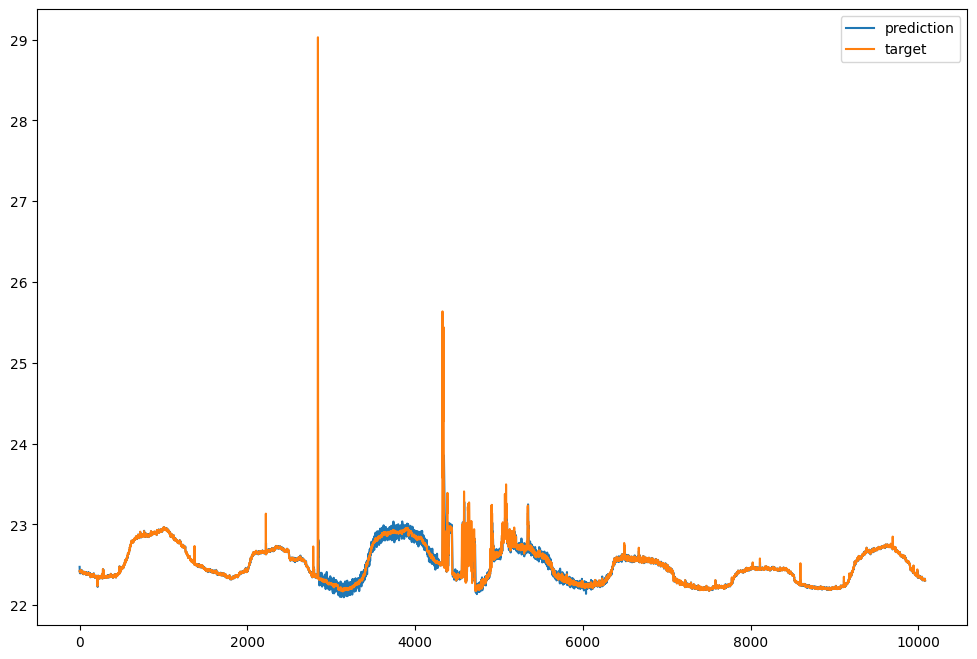

In [92]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [93]:
np.array(pred_list)

array([22.47337151, 22.41896248, 22.41413498, ..., 22.30387115,
       22.31479454, 22.30627441])

In [94]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[22.423888],
       [22.41452 ],
       [22.416   ],
       ...,
       [22.31816 ],
       [22.31004 ],
       [22.30716 ]])

In [95]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [96]:
print(SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

0.11708338279277086 %


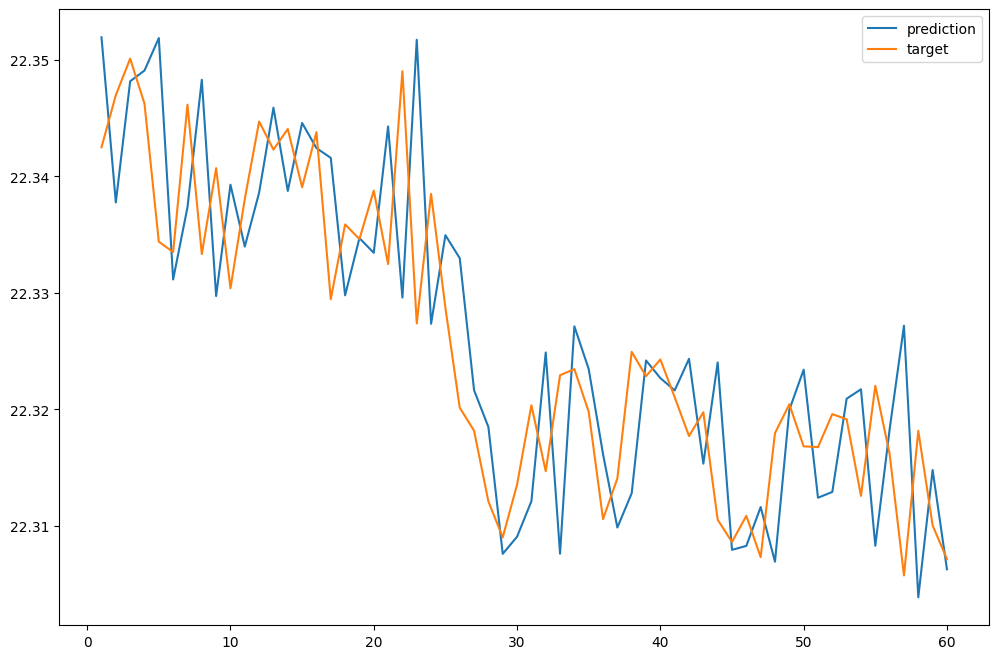

In [97]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [98]:
len(time_list)

10080

In [99]:
np.mean(time_list) 

0.2887492891578447

FIRST

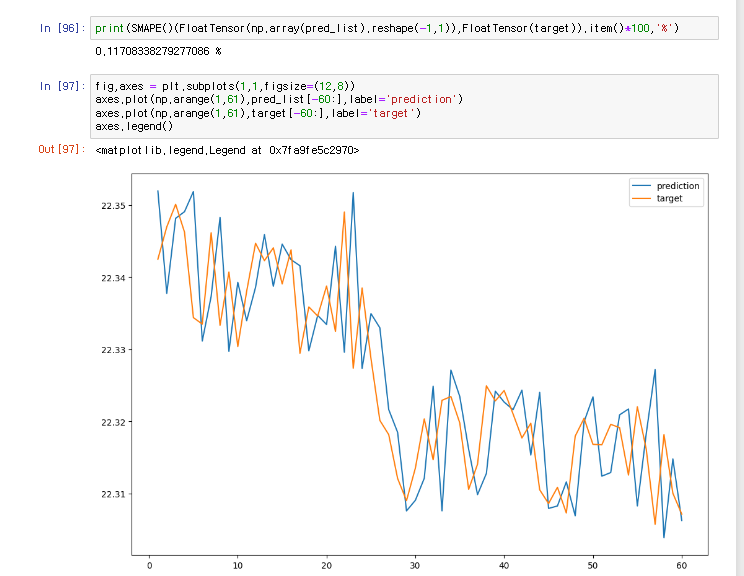